# Machine Learning for Trading (with Python)

Notebook for the "**Machine Learning for Trading with Python**" webinar done for futures.io.

&copy; Ran Aroussi | [@aroussi](http://twitter.com/aroussi) | [aroussi.com](http://aroussi.com) | [github.com/ranaroussi](https://github.com/ranaroussi)

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('notebook_repr_html', True)
pd.set_option('expand_frame_repr', False)

sns.set(font_scale=1.2, rc={
    'figure.figsize': (10, 7),
    'axes.facecolor':'white',
    'figure.facecolor':'white',
    'grid.color':'#dddddd',
    'grid.linewidth': 0.25,
    "lines.linewidth": 1.5,
    'text.color': 'gray',
    'xtick.color': 'gray',
    'ytick.color': 'gray'
})
# flat ui colors
flatui = ["#af4b64", "#3399cc", "#4fa487", "#9b59b6", "#95a5a6", 
          "#ee8659", "#4f6c86", "#254a82", "#c5a06e", "#cbb1b8"]
sns.set_palette(flatui)

# Machine Learning Algorithms

- **Unupervised Learning:** based on input
- **Supervised Learning:** based on input + output
- **Reinforced Learning:** based on feedback
- **Deep Learning:** based on nothing :)

---

# The Machine Learning Workflow

1. Data Gathering + Cleaning
- Feature Engineering + Normalization
- Model Selection
- Split Data
- Train Data
- Test Data

---

# Feature Engineering ≈ Alpha Factors

<big><br>Features are attributes that holds some predictive power over the end result</big>

**Examples:**

- Previous _N_ days returns
- Inter-market relationships
- Technical indicators

---

## Model Selection

<a href="http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html">
<img style="max-height:400px!important;padding:0 20px;margin:20px auto 0;" src="http://aroussi.com/assets/img/ml-map.jpg"></a>

Source: [scikit-learn.org](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

---

# Machine Learning for Trading

<img src="http://aroussi.com/assets/img/ml-sl.png" style="max-width:80%!important;">

# ML Algorithms for "Beginners"

<big><br>The two ML algorithems that are easiest to get started with are <strong>Decision Trees</strong> and <strong>K Nearest-Neighbours</strong>. They are both easy to comprehend and works for either Regression or Classification.</big>

## KNN (K Nearest-Neighbours)

- Training is fast
- Query is slow
- Requires data normalization
- Needs features

<img src="http://houseofbots.com/images/news/2542/cover.png" style="max-width:80%!important;">

## Decision Trees

- Training is slow
- Query is fast
- No need for data normalization
- Auto-discover features

<img src="http://aroussi.com/assets/img/ml-dt.png" style="max-width:90%!important;">


---

# Example: Predicting Tomorrow's Direction using a Decision Tree Algorithm

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

import fix_yahoo_finance as yf

## Get Data

In [4]:
symbols = ["^GSPC", "^VIX", "^VXV"]
raw = pd.read_pickle('ml-raw-data.pkl')
# raw = yf.download(symbols, start='1990-01-01', auto_adjust=True, group_by="symbol")

df = pd.DataFrame()
for symbol in symbols:
    new_symbol = symbol.replace("^", "").replace("GSPC", "SPX")
    df[new_symbol] = raw[symbol]['Close']

df.tail()

,SPX,VIX,VXV
Date,,,
2018-09-14,2904.979980,12.07,14.37
2018-09-17,2888.800049,13.68,15.28
2018-09-18,2904.310059,12.79,15.04
2018-09-19,2907.949951,11.75,14.65
2018-09-20,2932.149902,11.52,NaN


## Prepare Features (input)

In [5]:
df['SPXVOL'] = raw['^GSPC']['Volume'].pct_change() * 100
df['SPX1D']  = raw['^GSPC']['Close'].pct_change() * 100
df['VIX1D']  = raw['^VIX']['Close'].pct_change() * 100
df['VXV1D']  = raw['^VXV']['Close'].pct_change() * 100

df['SPXHL']  = raw['^GSPC']['Open'] - raw['^GSPC']['Low']
df['SPXOC']  = raw['^GSPC']['Open'] - raw['^GSPC']['Close']
df['SPXO2C'] = ((raw['^GSPC']['Close'] / raw['^GSPC']['Open']) - 1) * 100

df.dropna(inplace=True)
df.tail()

,SPX,VIX,VXV,SPXVOL,SPX1D,VIX1D,VXV1D,SPXHL,SPXOC,SPXO2C
Date,,,,,,,,,,
2018-09-13,2904.179932,12.37,14.77,-0.306285,0.528225,-5.859970,-3.590078,0.460205,-7.329834,0.253028
2018-09-14,2904.979980,12.07,14.37,-3.229870,0.027548,-2.425222,-2.708192,10.609863,1.399903,-0.048167
2018-09-17,2888.800049,13.68,15.28,-6.414376,-0.556972,13.338857,6.332637,17.670166,15.030029,-0.517593
2018-09-18,2904.310059,12.79,15.04,4.303268,0.536901,-6.505848,-1.570681,0.310058,-13.570069,0.469432
2018-09-19,2907.949951,11.75,14.65,6.680847,0.125327,-8.131353,-2.593085,2.780030,-1.349853,0.046441


## Prepare target (output)

In [6]:
df['target'] = np.where(df["SPXO2C"] >= 0, 1, np.where(df["SPXO2C"] < 0, -1, 0))
df['target'] = df['target'].shift(-1) # next day

df.dropna(inplace=True)
df.tail(10)

,SPX,VIX,VXV,SPXVOL,SPX1D,VIX1D,VXV1D,SPXHL,SPXOC,SPXO2C,target
Date,,,,,,,,,,,
2018-09-05,2888.600098,13.91,15.92,5.335938,-0.280313,5.699088,3.042071,14.670166,2.989990,-0.103403,-1.0
2018-09-06,2878.050049,14.65,16.34,-3.136444,-0.365231,5.319914,2.638191,21.349854,10.589844,-0.366603,1.0
2018-09-07,2871.679932,14.88,16.59,-6.157492,-0.221334,1.569966,1.529988,4.139893,-3.419922,0.119233,-1.0
2018-09-10,2877.129883,14.16,16.17,-7.292950,0.189783,-4.838710,-2.531646,5.449952,4.260010,-0.147846,1.0
2018-09-11,2887.889893,13.22,15.54,6.160211,0.373984,-6.638418,-3.896104,4.790039,-16.319825,0.568324,1.0
2018-09-12,2888.919922,13.14,15.32,12.596994,0.035667,-0.605144,-1.415701,9.090088,-0.629883,0.021808,1.0
2018-09-13,2904.179932,12.37,14.77,-0.306285,0.528225,-5.859970,-3.590078,0.460205,-7.329834,0.253028,-1.0
2018-09-14,2904.979980,12.07,14.37,-3.229870,0.027548,-2.425222,-2.708192,10.609863,1.399903,-0.048167,-1.0
2018-09-17,2888.800049,13.68,15.28,-6.414376,-0.556972,13.338857,6.332637,17.670166,15.030029,-0.517593,1.0


## Split Data into training and testing

In [7]:
feature_cols = [col for col in df.columns if col not in ['target']]

features = df[feature_cols].values
labels   = df['target'].values.flatten()

# split df
train_test_split = .9
sample = int( len(df.index) * train_test_split )

train_features = features[:-sample]
train_labels   = labels[:-sample]

test_features = features[-sample:]
test_labels   = labels[-sample:]

## Normalize data

In [8]:
# normalize
normalizer = preprocessing.Normalizer()
train_features = normalizer.fit(train_features).transform(train_features)

## Do ML Stuff

In [9]:
# init classifier
clf = DecisionTreeClassifier()

# fit 
clf.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [10]:
# predict
prediction = clf.predict(test_features)

# score
accuracy_score(test_labels, prediction)

0.5395213923132705

In [11]:
scores = cross_val_score(clf, features, labels, cv=10)
print("Mean %.2f%%, Std: %.2f" % (scores.mean()*100, scores.std()*100) )

Mean 50.96%, Std: 2.77


## Test Strategy

In [12]:
testdf = df[-sample:].copy()
testdf['predicted'] = prediction

testdf.tail()

,SPX,VIX,VXV,SPXVOL,SPX1D,VIX1D,VXV1D,SPXHL,SPXOC,SPXO2C,target,predicted
Date,,,,,,,,,,,,
2018-09-12,2888.919922,13.14,15.32,12.596994,0.035667,-0.605144,-1.415701,9.090088,-0.629883,0.021808,1.0,1.0
2018-09-13,2904.179932,12.37,14.77,-0.306285,0.528225,-5.859970,-3.590078,0.460205,-7.329834,0.253028,-1.0,1.0
2018-09-14,2904.979980,12.07,14.37,-3.229870,0.027548,-2.425222,-2.708192,10.609863,1.399903,-0.048167,-1.0,-1.0
2018-09-17,2888.800049,13.68,15.28,-6.414376,-0.556972,13.338857,6.332637,17.670166,15.030029,-0.517593,1.0,1.0
2018-09-18,2904.310059,12.79,15.04,4.303268,0.536901,-6.505848,-1.570681,0.310058,-13.570069,0.469432,1.0,1.0


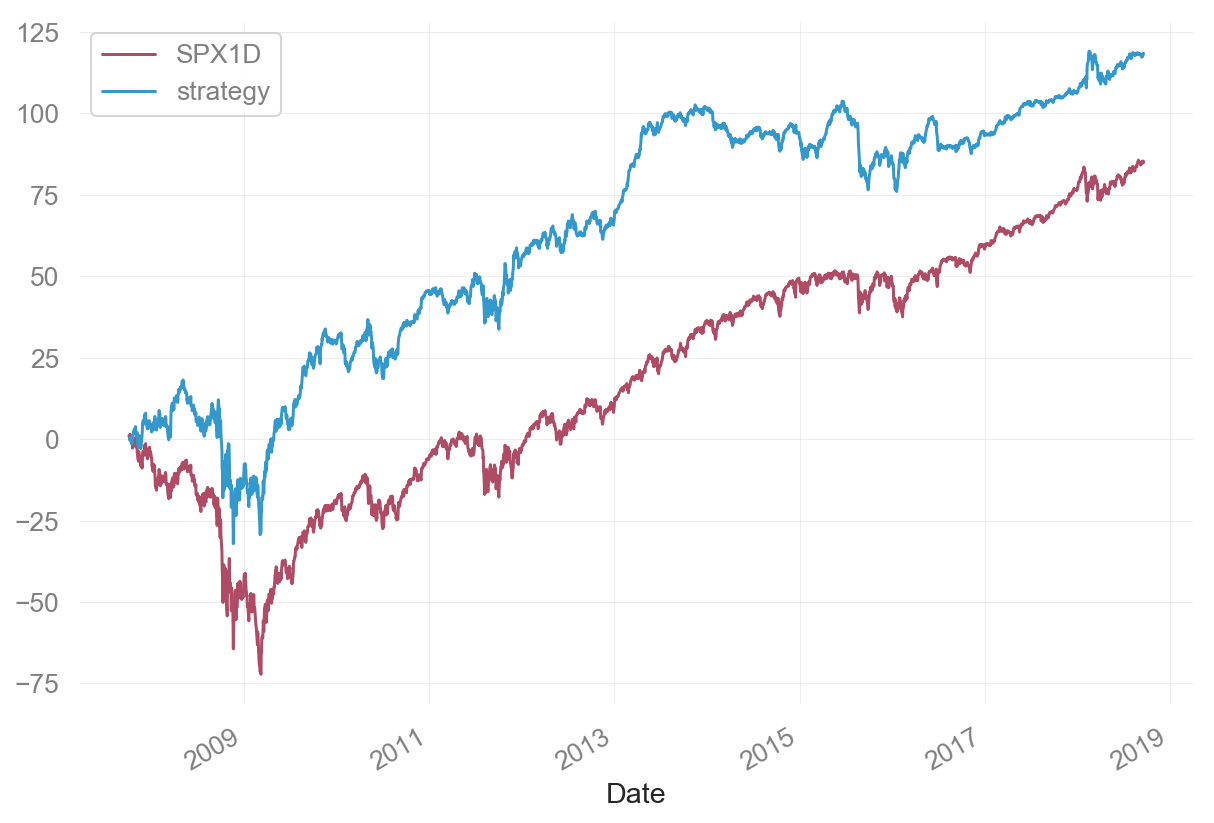

In [13]:
testdf['strategy'] = testdf['predicted'].shift(1) * testdf['SPXO2C']

testdf[['SPX1D', 'strategy']].cumsum().plot()

---

# and... We're Done :)

This was the part 4 out of the 4-part webinar series

- <strike>Prototyping Trading Strategies</strike>
- <strike>Backtesting & Optimization</strike>
- <strike>Live Trading</strike>
- <strike>Using Machine Learning in Trading</strike>

**Webinars available @ [aroussi.com/webinars](https://aroussi.com/webinars)**

---

# Further Reading

- [r2d3.us](http://www.r2d3.us)
- [It’s Been a Rough 2018 for Many Quant Hedge Funds (Bloomberg)](https://www.bloomberg.com/news/articles/2018-06-26/quants-beset-by-woes-as-jpmorgan-pulls-money-from-hedge-fund)
- [Why is machine learning in finance so hard (video)](https://www.youtube.com/watch?v=Szzp6pe4cns)
- [Coursera](https://www.coursera.org/learn/machine-learning) / [Udacity](https://www.udacity.com/school-of-ai)
- The Intraweb :)

---

# Machine Learning for Trading (with Python)

Notebook for the "**Machine Learning for Trading with Python**" webinar done for futures.io.

&copy; Ran Aroussi | [@aroussi](http://twitter.com/aroussi) | [aroussi.com](http://aroussi.com) | [github.com/ranaroussi](https://github.com/ranaroussi)